In [1]:
%load_ext autoreload

In [106]:
%autoreload 2

from copy import deepcopy
import itertools
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import colors
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from sklearn import manifold
import sys
import torch
from tqdm.auto import tqdm

plt.style.use('/om2/user/eisenaj/code/ChaoticConsciousness/sci_style.py')

sys.path.append('../..')
from data_utils import get_data_class, load_session_data, load_window_from_chunks, combine_grid_results

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *
from dmd import embed_signal_torch
from utils import numpy_torch_conversion

# Load Data

In [3]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [4]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

In [5]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [6]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [7]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]
puff_on = trial_info['cpt_puffOn'][~np.isnan(trial_info['cpt_puffOn'])]

# Load Results

In [12]:
results_dir = f"/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/ltsa_dim_reduction_multirun/{session}"

In [69]:
os.listdir(results_dir)

['pca_dims=12_delay_p=1_delay_tau=1_standardize=True_subsample=5_n_neighbors_pct=1.875',
 'pca_dims=9_delay_p=24_delay_tau=25_standardize=True_subsample=3_n_neighbors_pct=2.5',
 'pca_dims=15_delay_p=32_delay_tau=15_standardize=True_subsample=3_n_neighbors_pct=2.5',
 'pca_dims=12_delay_p=40_delay_tau=15_standardize=True_subsample=5_n_neighbors_pct=3.125',
 'pca_dims=15_delay_p=32_delay_tau=25_standardize=True_subsample=3_n_neighbors_pct=2.5',
 'pca_dims=12_delay_p=40_delay_tau=15_standardize=True_subsample=5_n_neighbors_pct=2.5',
 'pca_dims=12_delay_p=32_delay_tau=1_standardize=True_subsample=5_n_neighbors_pct=2.5',
 'pca_dims=15_delay_p=1_delay_tau=20_standardize=True_subsample=5_n_neighbors_pct=2.5',
 'pca_dims=-1_delay_p=4_delay_tau=1_standardize=True_subsample=5_n_neighbors_pct=2.5',
 'pca_dims=9_delay_p=40_delay_tau=15_standardize=True_subsample=1_n_neighbors_pct=1.875',
 'pca_dims=12_delay_p=1_delay_tau=20_standardize=True_subsample=3_n_neighbors_pct=2.5',
 'pca_dims=9_delay_p=24_

In [68]:
# os.listdir(results_dir)
fs = [f for f in os.listdir(results_dir) if int(f.split('=')[1].split('_')[0]) == -1]

In [87]:
pca_dims = 9
delay_p = 24
delay_tau = 15
standardize = True
subsample = 1
n_neighbors_pct = 2.5
run_dir = f"pca_dims={pca_dims}_delay_p={delay_p}_delay_tau={delay_tau}_standardize={standardize}_subsample={subsample}_n_neighbors_pct={n_neighbors_pct}"

In [88]:
all_embedded_signals = {}
time_vals = np.sort([float('.'.join(t.split('.')[:2])) for t in os.listdir(os.path.join(results_dir, run_dir))])
for t in time_vals:
    all_embedded_signals[t] = pd.read_pickle(os.path.join(results_dir, run_dir, f"{t:.3f}.pkl"))

In [89]:
time_vals

array([ 547.001, 1968.237])

# Plot

In [90]:
window = 30
dt = 0.001

In [91]:
all_embedded_signals.keys()

dict_keys([547.001, 1968.237])

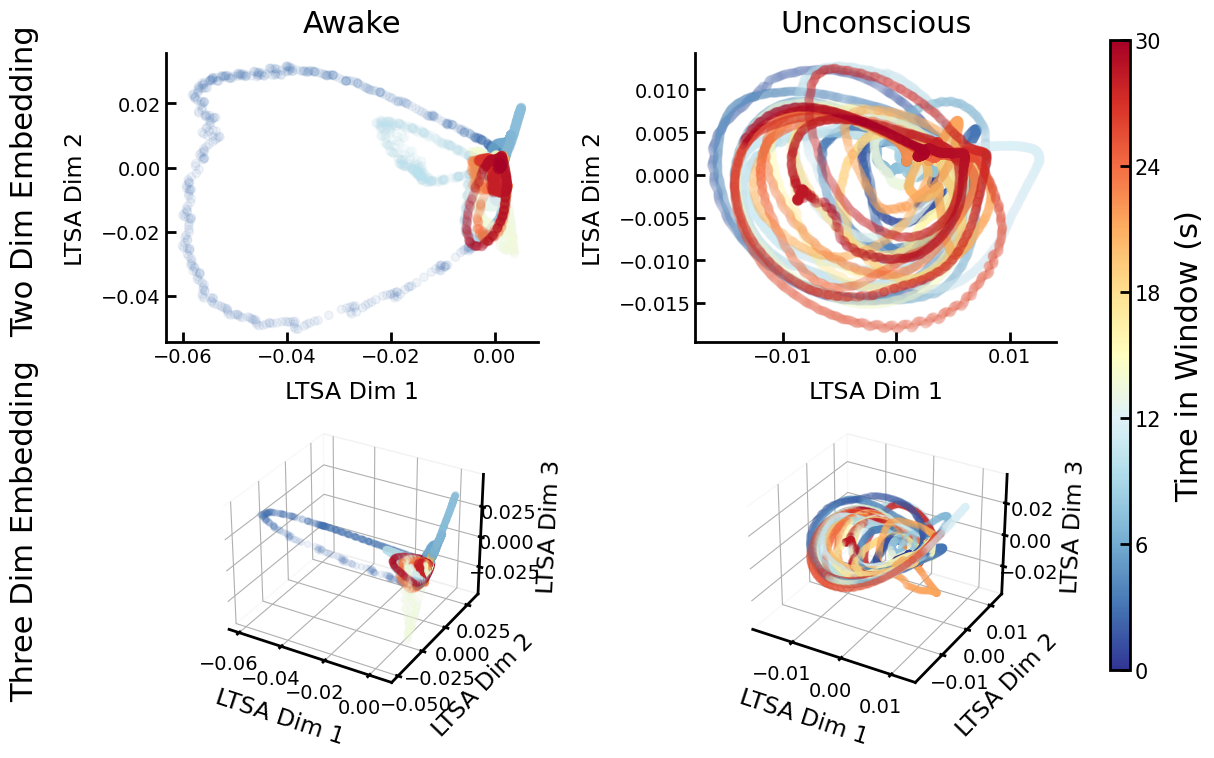

In [92]:
# Combo Plot
embed_func = 'ltsa'

ysuplabel_fontsize = 22
xlabel_fontsize = 17
ylabel_fontsize = 17
zlabel_fontsize = 17
title_fontsize = 22
tick_fontsize = 14
clabel_fontsize = 22

alpha = 0.075

fig = plt.figure(layout='constrained', figsize=(10, 7))
subfigs = fig.subfigures(1, 2, wspace=0.07, hspace=0.07)

for plot_ind, t in enumerate(all_embedded_signals.keys()):

    
    embedded_signals = {}
    embedded_signals[embed_func] = all_embedded_signals[t]

    cmap = plt.cm.get_cmap('RdYlBu_r')
    color_list4 = cmap(np.linspace(0, 1, int(window/dt)))

    axs = subfigs[plot_ind].subplots(2, 1)
    axs[0].scatter(embedded_signals[embed_func][:, 0], embedded_signals[embed_func][:, 1], color=np.array(color_list4)[np.arange(0, int(window/dt), subsample)][-embedded_signals[embed_func].shape[0]:], alpha=alpha)
    axs[1].remove()
    axs[1]=subfigs[plot_ind].add_subplot(2, 1, 2, projection='3d')
    axs[1].scatter(embedded_signals[embed_func][:, 0], embedded_signals[embed_func][:, 1], embedded_signals[embed_func][:, 2], color=np.array(color_list4)[np.arange(0, int(window/dt), subsample)][-embedded_signals[embed_func].shape[0]:], alpha=alpha)
    
    axs[1].w_xaxis.pane.fill = False
    axs[1].w_yaxis.pane.fill = False
    axs[1].w_zaxis.pane.fill = False
    
    axs[0].spines[['right', 'top']].set_visible(False)
    axs[0].xaxis.set_ticks_position('bottom')
    axs[0].tick_params(axis='y', which='both', left=True, right=False)
    for ax in axs:
        ax.set_xlabel('LTSA Dim 1', fontsize=xlabel_fontsize)
        ax.set_ylabel('LTSA Dim 2', fontsize=ylabel_fontsize)
        ax.tick_params(labelsize=tick_fontsize)
    axs[1].set_zlabel('LTSA Dim 3', fontsize=zlabel_fontsize)
    
    axs[0].set_title(['Awake', 'Unconscious'][plot_ind], fontsize=title_fontsize)
    
    if plot_ind == 0:
        fig.text(-0.05, 0.75, 'Two Dim Embedding', va='center', rotation='vertical', fontsize=ysuplabel_fontsize)
        fig.text(-0.05, 0.25, 'Three Dim Embedding', va='center', rotation='vertical', fontsize=ysuplabel_fontsize)


# stack = np.vstack((plt.cm.get_cmap('BuGn')(np.linspace(0, 1, 128)), plt.cm.get_cmap('YlOrRd')(np.linspace(0, 1, 128))))
# mymap = colors.LinearSegmentedColormap.from_list('my_colormap', stack)
# fig.legend(bbox_to_anchor=(0.5, -0.1), loc='center', ncol=5)

sm = plt.cm.ScalarMappable(cmap=cmap)
# fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.05, 0.05, 0.02, 0.9])
cbar = fig.colorbar(sm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], cax=cbar_ax)
cbar.ax.set_yticklabels([0, 6, 12, 18, 24, 30], fontsize=15)
cbar.set_label('Time in Window (s)', fontsize=clabel_fontsize)

plt.show()

In [48]:
# Combo Plot

# stim_length = 1000
stim_length = 3000

ysuplabel_fontsize = 22
xlabel_fontsize = 17
ylabel_fontsize = 17
zlabel_fontsize = 17
title_fontsize = 22
tick_fontsize = 14

alpha = 0.075

fig = plt.figure(layout='constrained', figsize=(10, 7))
subfigs = fig.subfigures(1, 2, wspace=0.07, hspace=0.07)

for plot_ind, t in enumerate(all_embedded_signals.keys()):

    
    embedded_signals = {}
    embedded_signals[embed_func] = all_embedded_signals[t]
    
    color_list4 = np.array([(1/256, 1/256, 1/256, 1.0)]*len(color_list))

    for t_tone in tone_on[np.logical_and(tone_on >= t, tone_on <= t + window)]:
        start = int((t_tone - t)/dt)
        end = np.min([int((t_tone - t)/dt) + stim_length, len(color_list)])
        color_list4[start:end] = plt.cm.get_cmap('BuGn')(np.linspace(0, 1, end-start))
#         subsampled_inds = np.arange(int(window/dt))[np.arange(0, int(window/dt), subsample)]
#         plot_inds = np.where(np.logical_and(subsampled_inds >= start, subsampled_inds < end))[0]
#         plot_inds -= int((delay_p - 1)*delay_tau/subsample)

    for t_puff in puff_on[np.logical_and(puff_on >= t, puff_on <= t + window)]:
        start = int((t_puff - t)/dt)
        end = np.min([int((t_puff - t)/dt) + stim_length, len(color_list)])
        color_list4[start:end] = plt.cm.get_cmap('YlOrRd')(np.linspace(0, 1, end-start))

    #     alpha[input_vec > 0] = 1
    #     alpha = alpha[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:]

    
#     prev_val = None
#     power = 0
#     for i, input_val in enumerate(input_vec):

#         if prev_val == input_val:
#             power += 1
#         else:
#             power = 0
#         if input_val == 1:
#             B = np.linspace(0.5717531718569781, 1, 1000)
#             color_list4[i] = (0.5056516724336794, 0.7190311418685121, B[power], 1.0)
#         elif input_val == 3:
#             G = np.linspace(0.6173779315647828, 1, 1000)
#             color_list4[i] = (0.9831603229527105, G[power], 0.35040369088811996, 1.0)
#         elif input_val == 4:
#             R = np.linspace(0.8417531718569781, 1, 1000)
#             color_list4[i] = (R[power], 0.9690119184928874, 0.7020376778162245, 1.0)
#         if i > 0:
#             prev_val = input_vec[i - 1]

    # plt.figure(figsize=(8, 5))
    axs = subfigs[plot_ind].subplots(2, 1)
    axs[0].scatter(embedded_signals[embed_func][:, 0], embedded_signals[embed_func][:, 1], color=np.array(color_list4)[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:], alpha=alpha)
    axs[1].remove()
    axs[1]=subfigs[plot_ind].add_subplot(2, 1, 2, projection='3d')
    axs[1].scatter(embedded_signals[embed_func][:, 0], embedded_signals[embed_func][:, 1], embedded_signals[embed_func][:, 2], color=np.array(color_list4)[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:], alpha=alpha)
    
    axs[1].w_xaxis.pane.fill = False
    axs[1].w_yaxis.pane.fill = False
    axs[1].w_zaxis.pane.fill = False
    
    axs[0].spines[['right', 'top']].set_visible(False)
    axs[0].xaxis.set_ticks_position('bottom')
    axs[0].tick_params(axis='y', which='both', left=True, right=False)
    for ax in axs:
        ax.set_xlabel('LTSA Dim 1', fontsize=xlabel_fontsize)
        ax.set_ylabel('LTSA Dim 2', fontsize=ylabel_fontsize)
        ax.tick_params(labelsize=tick_fontsize)
    axs[1].set_zlabel('LTSA Dim 3', fontsize=zlabel_fontsize)
    
    axs[0].set_title(['Awake', 'Unconscious'][plot_ind], fontsize=title_fontsize)
    
    if plot_ind == 0:
        fig.text(-0.05, 0.75, 'Two Dim Embedding', va='center', rotation='vertical', fontsize=ysuplabel_fontsize)
        fig.text(-0.05, 0.25, 'Three Dim Embedding', va='center', rotation='vertical', fontsize=ysuplabel_fontsize)


stack = np.vstack((plt.cm.get_cmap('BuGn')(np.linspace(0, 1, 128)), plt.cm.get_cmap('YlOrRd')(np.linspace(0, 1, 128))))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', stack)
# fig.legend(bbox_to_anchor=(0.5, -0.1), loc='center', ncol=5)

sm = plt.cm.ScalarMappable(cmap=mymap)
# fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.05, 0.05, 0.02, 0.9])
cbar = fig.colorbar(sm, ticks=[0.25, 0.75], cax=cbar_ax)
cbar.ax.set_yticklabels([f"Tone Response ({int(stim_length*dt)}s)", f"Airpuff Response ({int(stim_length*dt)}s)"], fontsize=15)

plt.show()

NameError: name 'color_list' is not defined

<Figure size 1000x700 with 0 Axes>

In [ ]:
cmap_names = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples']
# cmap_names = ['Blues', 'Oranges', 'Greens', 'Purples', 'Greys']

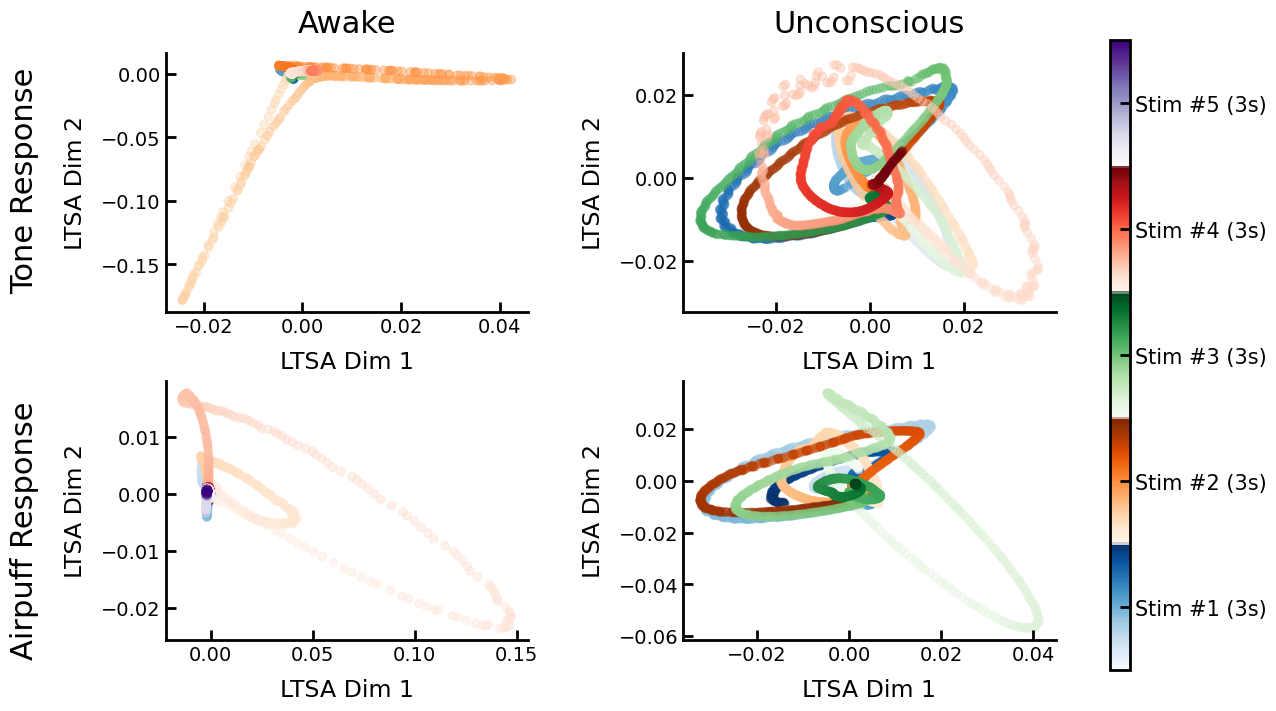

In [ ]:
# stim_length = 1000
stim_length = 3000
ysuplabel_fontsize = 22
xlabel_fontsize = 17
ylabel_fontsize = 17
title_fontsize = 22
tick_fontsize = 14

embedded_signals = {}
embedded_signals[embed_func] = all_embedded_signals[t][embed_func]

input_vec = np.zeros(len(color_list))
alpha = 0.4

fig = plt.figure(layout='constrained', figsize=(10, 7))
subfigs = fig.subfigures(1, 2, wspace=0.07, hspace=0.07)

for plot_ind, t in enumerate(all_embedded_signals.keys()):
    
#     axs = subfigs[plot_ind].subplots(4, 1)
    axs = subfigs[plot_ind].subplots(2, 1)
    
    embedded_signals = {}
    embedded_signals[embed_func] = all_embedded_signals[t][embed_func]
    
#     input_vec = np.zeros(len(color_list))

#     for t_tone in tone_on[np.logical_and(tone_on >= t, tone_on <= t + window)]:
#         start = int((t_tone - t)/dt)
#         end = np.min([int((t_tone - t)/dt) + 1000, len(color_list)])
#         input_vec[start:end] += 1

#     for t_puff in puff_on[np.logical_and(puff_on >= t, puff_on <= t + window)]:
#         start = int((t_puff - t)/dt)
#         end = np.min([int((t_puff - t)/dt) + 1000, len(color_list)])
#         input_vec[start:end] += 3

#     #     alpha[input_vec > 0] = 1
#     #     alpha = alpha[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:]

#     color_list4 = [(1/256, 1/256, 1/256, 1.0)]*len(color_list)
#     prev_val = None
#     power = 0
#     for i, input_val in enumerate(input_vec):

#         if prev_val == input_val:
#             power += 1
#         else:
#             power = 0
#         if input_val == 1:
#             B = np.linspace(0.5717531718569781, 1, 1000)
#             color_list4[i] = (0.5056516724336794, 0.7190311418685121, B[power], 1.0)
#         elif input_val == 3:
#             G = np.linspace(0.6173779315647828, 1, 1000)
#             color_list4[i] = (0.9831603229527105, G[power], 0.35040369088811996, 1.0)
#         elif input_val == 4:
#             R = np.linspace(0.8417531718569781, 1, 1000)
#             color_list4[i] = (R[power], 0.9690119184928874, 0.7020376778162245, 1.0)
#         if i > 0:
#             prev_val = input_vec[i - 1]

#     # plt.figure(figsize=(8, 5))
#     axs[0].scatter(embedded_signals[embed_func][:, 0], embedded_signals[embed_func][:, 1], color=np.array(color_list4)[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:], alpha=alpha)
#     axs[1].remove()
#     axs[1]=subfigs[plot_ind].add_subplot(4, 1, 2, projection='3d')
#     axs[1].scatter(embedded_signals[embed_func][:, 0], embedded_signals[embed_func][:, 1], embedded_signals[embed_func][:, 2], color=np.array(color_list4)[np.arange(0, len(color_list), subsample)][-embedded_signals[embed_func].shape[0]:], alpha=alpha)
    
    for tone_num, t_tone in enumerate(tone_on[np.logical_and(tone_on >= t, tone_on <= t + window)]):

        tone_colors = np.zeros((stim_length, 4))
        cmap = plt.cm.get_cmap(cmap_names[tone_num])
        norm = Normalize(0, stim_length)
        for i in range(stim_length):
            tone_colors[i] = cmap(norm(i))
        tone_colors = tone_colors[np.arange(0, stim_length, subsample)]

        start = int((t_tone - t)/dt)
        end = np.min([int((t_tone - t)/dt) + stim_length, len(color_list)])
    #     input_vec[start:end] += 1
        subsampled_inds = np.arange(int(window/dt))[np.arange(0, int(window/dt), subsample)]
        plot_inds = np.where(np.logical_and(subsampled_inds >= start, subsampled_inds < end))[0]
        plot_inds -= int((delay_p - 1)*delay_tau/subsample)
        

#         dist = compute_start_end_distance(embedded_signals[embed_func][plot_inds])
#         print(f"t = {t}, tone {tone_num} = {dist}")
        
        axs[0].scatter(embedded_signals[embed_func][plot_inds, 0], embedded_signals[embed_func][plot_inds, 1], c=tone_colors[:len(plot_inds)], alpha=alpha)

#         axs[0].scatter([], [], color=cmap(norm(500)), alpha=alpha, label=f'Tone #{tone_num}')

#         axs[0].legend()

    for puff_num, t_puff in enumerate(puff_on[np.logical_and(puff_on >= t, puff_on <= t + window)]):

        puff_colors = np.zeros((stim_length, 4))
        cmap = plt.cm.get_cmap(cmap_names[puff_num])
        norm = Normalize(0, stim_length)
        for i in range(stim_length):
            puff_colors[i] = cmap(norm(i))
        puff_colors = puff_colors[np.arange(0, stim_length, subsample)]

        start = int((t_puff - t)/dt)
        end = np.min([int((t_puff - t)/dt) + stim_length, int(window/dt)])
    #     input_vec[start:end] += 1
        subsampled_inds = np.arange(int(window/dt))[np.arange(0, int(window/dt), subsample)]
        plot_inds = np.where(np.logical_and(subsampled_inds >= start, subsampled_inds < end))[0]
        plot_inds -= int((delay_p - 1)*delay_tau/subsample)
        
#         dist = compute_start_end_distance(embedded_signals[embed_func][plot_inds])
#         print(f"t = {t}, puff {puff_num} = {dist}")

        axs[1].scatter(embedded_signals[embed_func][plot_inds, 0], embedded_signals[embed_func][plot_inds, 1], c=puff_colors[:len(plot_inds)], alpha=alpha)

#         axs[1].scatter([], [], color=cmap(norm(500)), alpha=alpha, label=f'Puff #{puff_num}')

#         axs[1].legend()
    for ax in axs:
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='y', which='both', left=True, right=False)
        ax.set_xlabel('LTSA Dim 1', fontsize=xlabel_fontsize)
        ax.set_ylabel('LTSA Dim 2', fontsize=ylabel_fontsize)
        ax.tick_params(labelsize=tick_fontsize)
    
    axs[0].set_title(['Awake', 'Unconscious'][plot_ind], fontsize=title_fontsize)
    if plot_ind == 0:
        fig.text(-0.05, 0.75, 'Tone Response', va='center', rotation='vertical', fontsize=ysuplabel_fontsize)
        fig.text(-0.05, 0.25, 'Airpuff Response', va='center', rotation='vertical', fontsize=ysuplabel_fontsize)
#         axs[0].set_ylabel('')
#         axs[0].set_ylabel('Tone Response')
#         axs[1].set_ylabel('Airpuff Response')

stack = None
for ind in range(len(cmap_names)):
    cmap = plt.cm.get_cmap(cmap_names[ind])
    if stack is None:
        stack = cmap((np.linspace(0, 1, 128)))
    else:
        stack = np.vstack([stack, cmap(np.linspace(0, 1, 128))])
# stack = np.vstack((plt.cm.get_cmap(cmap_names[0]), plt.cm.get_cmap(cmap_names[1])(np.linspace(0, 1, 128))))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', stack)
# fig.legend(bbox_to_anchor=(0.5, -0.1), loc='center', ncol=5)

sm = plt.cm.ScalarMappable(cmap=mymap)
# fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.05, 0.05, 0.02, 0.9])
cbar = fig.colorbar(sm, ticks=np.arange(0.1, 1.01, 0.2), cax=cbar_ax)
cbar.ax.set_yticklabels([f"Stim #{i + 1} ({int(stim_length*dt)}s)" for i in range(5)], fontsize=15)

    # cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(0, 1000, 100), label='Time Relative to Tone (ms)')
    # # cbar.ax.set_yticklabels(np.arange(start_ind, end_ind + 1, cbar_step), fontsize=12)
    # cbar.set_label(label=f'Time Relative to Tone Onset (s)', fontsize=14)

    # for t_puff in puff_on[np.logical_and(puff_on >= t, puff_on <= t + window)]:
    #     start = int((t_puff - t)/dt)
    #     end = np.min([int((t_puff - t)/dt) + 1000, len(color_list)])
    #     input_vec[start:end] += 3
    

    
plt.show()

# Extra

In [93]:
dir_ = f"/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat/propofolPuffTone/{session}_lfp_chunked_20s"
directory = pd.read_pickle(os.path.join(dir_, "directory"))

In [98]:
areas_to_include = ['vlPFC', 'FEF', '7b', 'CPB']
electrode_indices = np.array([False]*len(electrode_info['area']))
for area in areas_to_include:
    electrode_indices = np.logical_or(electrode_indices, electrode_info['area'] == area)
electrode_indices = np.where(electrode_indices)[0]

In [103]:
print("Loading grid search results...")

norm_folder = "NOT_NORMED"
    
session_results = {}
session_results[session] = {}
# data_processing_df_grid = deepcopy(mp_args.data_processing_df)

grid_results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results'
areas = os.listdir(os.path.join(grid_results_dir, session, norm_folder))

for area in areas:
    df = pd.DataFrame({'window': [], 'matrix_size': [], 'r': [], 'AICs': [], 'time_vals': [], 'file_paths': []}).set_index(['window', 'matrix_size', 'r'])
    for f in os.listdir(os.path.join(grid_results_dir, session, norm_folder, area)):
        t = float(f.split('_')[0])
        file_path = os.path.join(grid_results_dir, session, norm_folder, area, f)
        df_new = pd.DataFrame(pd.read_pickle(file_path))
        if np.isnan(df_new.AIC).sum() > 0:
            print(file_path)
        df_new = df_new.set_index(['window', 'matrix_size', 'r'])
        for i, row in df_new.iterrows():
            if i in df.index:
                df.loc[i, 'AICs'].append(row.AIC)
                df.loc[i, 'time_vals'].append(t)
                df.loc[i, 'file_paths'].append(file_path)
            else:
                df.loc[i] = {'AICs': [row.AIC], 'time_vals': [t], 'file_paths': [file_path]}

    df = df.loc[df.index.sortlevel()[0]]
    session_results[session][area] = df

    print("Grid search results loaded!")

Loading grid search results...
Grid search results loaded!
Grid search results loaded!
Grid search results loaded!
Grid search results loaded!
Grid search results loaded!


In [107]:
window_all, matrix_size_all, r_all, all_results_all = combine_grid_results({key: result for key, result in session_results[session].items() if key =='all'})

In [95]:
for t in time_vals:
    break

In [99]:
signal = load_window_from_chunks(t, t + window, directory, electrode_indices)
train_signal = signal[:window_all]
test_signal = signal[window_all:2*window_all]

In [110]:
delase = DeLASE(train_signal, matrix_size=matrix_size_all, rank=r_all, dt=dt)

In [111]:
delase.fit()

In [113]:
preds = delase.DMD.predict()

In [ ]:
()